# NOMOR 1: AB Testing
Welcome! In this assignment you will be presented with two cases that require an AB test to choose an action to improve an existing product. You will perform AB test for a continuous and a proportion metric. For this you will define functions that estimate the relevant information out of the samples, compute the relevant statistic given each case and take a decision on whether to (or not) reject the null hypothesis.

Let's get started!

# Outline
- [ 1 - Introduction](#1)
- [ 2 - Exploring and handling the data](#2)
- [ 3 - Theory](#3)
- [ 4 - Step by step computation](#4)
  - [ Exercise 1](#ex01)
  - [ Exercise 2](#ex02)
  - [ Exercise 3](#ex03)
  - [ Exercise 4](#ex04)
  - [ Exercise 5](#ex05)

# Warning!!!
You just need to run each code and only change the **`None` part** of the exercise.


In [ ]:
import math
import numpy as np
import pandas as pd
from scipy import stats

<a name="1"></a>
## 1 - Introduction

Suppose you have a website that provides Data Mining content in a blog-like format. Recently you saw an article claiming that similar websites could improve their engagement by simply using a specific color palette for the background. Since this change seems pretty easy to implement you decide to run an AB test to see if this change does in fact drive your users to stay more time in your website.

The metric you decide to evaluate is the `average session duration`, which measures how much time on average your users are spending on your website. This metric currently has a value of 30.87 minutes.

Without further considerations you decide to run the test for 20 days by randomly splitting your users into two segments:
- `control`: These users will keep seeing your original website.


- `variation`: These users will see your website with the new background colors.

<a name="2"></a>
## 2 - Exploring and handling the data

Run the next cell to load the data from the test:

In [ ]:
# Load the data from the test using pd.read_csv
data = pd.read_csv("Data Nomor 1.csv")

# Print the first 10 rows
data.head(10)

,Unnamed: 0,user_id,user_type,session_duration
0,0,QVG11G7WWU,control,13.450484
1,1,U1XK1H0902,variation,25.627093
2,2,OX21E1HF0T,variation,11.145770
3,3,C1UODTFLDI,variation,28.742150
4,4,WOSAMYWSBP,control,24.333361
5,5,EXVE2C6LJX,variation,24.882516
6,6,9UQ64WA0S4,control,31.589878
7,7,EQ6GA0KKF1,variation,23.154885
8,8,YWYW3YJDRR,control,39.267641
9,9,GPSGHXWZXZ,variation,32.899850


In [ ]:
print(f"The dataset size is: {len(data)}")

The dataset size is: 4186


The data shows for every user the average session duration and the version of the website they interacted with. To separate both segments for easier computations you can slice the Pandas dataframe by running the following cell.

In [ ]:
# Separate the data from the two groups (sd stands for session duration)
control_sd_data = data[data["user_type"]=="control"]["session_duration"]
variation_sd_data = data[data["user_type"]=="variation"]["session_duration"]

print(f"{len(control_sd_data)} users saw the original website with an average duration of {control_sd_data.mean():.2f} minutes\n")
print(f"{len(variation_sd_data)} users saw the new website with an average duration of {variation_sd_data.mean():.2f} minutes")

2069 users saw the original website with an average duration of 32.92 minutes



2117 users saw the new website with an average duration of 33.83 minutes


Notice that the split is not perfectly balanced. This is common in AB testing as there is randomness associated with the way the users are assigned to each group.

At first glance it looks like the change to the background did in fact drive users to stay longer on your website. However you know better than driving conclusions at face value out of this data so you decide to perform a hypothesis test to know if there is a significant difference between the **means** of these two segments.

<a name="3"></a>
## 3 - Theory
Remember that your job is to measure if changing the website's background color leads to an increase of the time visitors spend on it. Rewriting this as hypothesis test, the **null hypothesis** is that the change did not affect the time a visitor spend. Let's name the variables:

- $\mu_c$ is the average time a user **in the control group** spend in the website. Recall that the **control group** is the group accessing the website without the change in the background color.
- $\mu_v$ is the average time a user **in the variation groups** spend in the website. Recall that the **variation group** is the groups accessing the website **with the updated background color**.

Also, recall that your intention is to measure if the background color leads to an **increase** in the time a visitor spend in the website. So writing this experiment as a hypothesis test, the **null hypothesis** is then $H_0: \mu_c = \mu_v$ and the **alternative hypothesis** is $H_1: \mu_v > \mu_c$, or equivalently, $H_1: \mu_v - \mu_c > 0$.

Therefore, the hypothesis you will test is:

$$H_0: \mu_v = \mu_c \quad \text{vs.} \quad H_1: \mu_v - \mu_c > 0$$

As you know, this is a **right-tailed** test, as you are looking for an increase in the average time. As you saw above, you have more than 2000 users per group, this is a great amount of data so it is reasonable to rely in the Central Limit Theorem that the **average time** for each group follows a normal distribution. Remember that this result is for the group **average time** altogether and not that the time each user spend follows a normal distribution. You don't know the exact distribution for the amount of time a user spend in your website, however, the CLT assures that if we gather enough data, their average time will be very close to a normal distribution whose mean is the average time a user spend in the website. Let's then define two new quantities:

- $\overline{X}_c$ - the control group **sample mean**.
- $\overline{X}_v$ - the variation group **sample mean**.
- $n_c$ - the control group **size**.
- $n_v$ - the variation group **size**.

So, by the Central Limit Theorem, you may suppose that

- $$\overline{X}_c \sim N\left(\mu_c, \left(\frac{\sigma_c}{\sqrt{n_c}}\right)^2\right)$$
- $$\overline{X}_v \sim N\left(\mu_v, \left(\frac{\sigma_v}{\sqrt{n_v}}\right)^2\right)$$

Note that with our assumptions of normality, $\overline{X}_v - \overline{X}_c$ also follows a normal distribution. So, if $H_0$ is true, then $\mu_c = \mu_v$ and $\mu_v - \mu_c = 0$, therefore:

$$\overline{X}_c - \overline{X}_v \sim N\left(\mu_v - \mu_c, \left(\dfrac{\sigma_v}{\sqrt{n_v}}\right)^2 + \left(\dfrac{\sigma_c}{\sqrt{n_c}}\right)^2\right) = N\left(0, \left(\dfrac{\sigma_v}{\sqrt{n_v}}\right)^2 + \left(\dfrac{\sigma_c}{\sqrt{n_c}}\right)^2\right)$$

Or, equivalently:

$$\frac{\left( \overline{X}_v - \overline{X}_c \right)}{\sqrt{\left(\frac{\sigma_v}{\sqrt{n_v}}\right)^2 + \left(\frac{\sigma_c}{\sqrt{n_c}}\right)^2}} \sim N(0, 1)$$

However, remember that **you don't know the exact values for** $\sigma_v$ and $\sigma_c$, as they are the **population standard deviation** and you are working with a sample, so the best you can do is compute the **sample standard deviation**. So you must replace $\sigma_c$ and $\sigma_v$ by the sample standard deviation, respectively, $s_c$ and $s_v$. As you know that replacing the population standard deviation by the sample standard deviation changes the random variable from a Normal to a t-student:

$$t = \frac{\left( \overline{X}_v - \overline{X}_c \right)}{\sqrt{\left(\frac{s_v}{\sqrt{n_v}}\right)^2 + \left(\frac{s_c}{\sqrt{n_c}}\right)^2}} \sim t_d$$

Where $d$ is the **degrees of freedom** for this scenario. If we suppose that both groups have the same standard deviation, then $d = n_c + n_v - 2$, however there is no argument supporting this supposition, so the formula for the degrees of freedom gets a bit messier:

$$d = \frac{\left[\frac{s_{v}^2}{n_v} + \frac{s_{c}^2}{n_c} \right]^2}{\frac{(s_{v}^2/n_v)^2}{n_v-1} + \frac{(s_{c}^2/n_c)^2}{n_c-1}}$$

Once you get the actual value for $t_d$ the, with a given significance level $\alpha$, you can decide if this value falls within the range of values that are likely to occur in the $t$-student distribution (where 'likely' is related with your significance level). To perform this step you must find the value $p$ such that

$$p = P(t_d > t | H_0)$$

If this value is less than your significance level $\alpha$, then you **reject the null hypothesis**, because it means that you observed a value that is very unlikely to occur (unlikely here means that is less than the significance level you have set) if $H_0$ is true.

Also, remember that $P(t_d \leq t)$ is the $\text{CDF}$ (cumulative distribution function) for the $t$-student distribution with $d$ degrees of freedom in the point $x = t$, so to compute $P(t_d > t)$ you may compute:

$$P(t_d > t) = 1 - \text{CDF}_{t_d}(t)$$

Since $P(t_d \leq t) + P(t_d > t) = 1$

<a name="4"></a>
## 4 - Step by step computation


Wrapping up everything discussed above:

The hypothesis test is given by:

$$H_0: \mu_v = \mu_c \quad \text{vs.} \quad H_1: \mu_v - \mu_c > 0$$

You will start computing:

- $n_c$ and $n_v$, the control and variation group sizes, respectively.
- $\overline{X}_c$ and $\overline{X}_v$, the average time spent by the users in the control and variation group, respectively.
- $s_c$ and $s_v$, the **sample** standard deviation for the time spend by the users in the control and variation group, respectively.

With these quantities in hand, the next steps are to compute:

- $d$, the degrees of freedom of the $t$-student distribution, $t_d$.
- The $t$-value, which it will be called $t$.
- The $p$ value for the distribution $t_d$ for the $t$-value, i.e., the value  $p = P(t_d > t | H_0)$.

Finally, for a given significance level $\alpha$, you will be able to decide if you reject or not $H_0$, depending on wether $p \leq \alpha$ or not.

Let's get your hands into work now! Run the cell below to retrieve the session times for the control and variation groups.

In [ ]:
# X_c stores the session tome for the control group and X_v, for the variation group.
X_c = control_sd_data.to_numpy()
X_v = variation_sd_data.to_numpy()

In [ ]:
print(f"The first 10 entries for X_c are:\n{X_c[:20]}\n")
print(f"The first 10 entries for X_v are:\n{X_v[:20]}\n")

The first 10 entries for X_c are:

[13.45048373 24.333361   31.58987847 39.26764149 32.61917775 32.98192154

 26.51860511 15.90155398 49.44019133 73.14088446 72.0610985  54.72090992

 13.96151434 22.4044191  47.62731876 70.23490949  9.86928486 20.41082

 25.58036315 18.42237817]



The first 10 entries for X_v are:

[25.62709264 11.14577013 28.74215044 24.88251582 23.15488489 32.89985019

 42.31885548 21.80989603 30.38106919 26.61549768 38.38533537 26.85079489

 31.08674693 33.50466599 44.40412162 39.83845579 19.11518102 31.96903999

 18.11653876 37.16189333]




<a name="ex01"></a>
### Exercise 1

In this exercise, you will write a function to retrieve the basic statistics for `X_c` and `X_d`. In other words, this function will compute, for a given numpy array:

- Its size (in your case, $n_c$ and $n_v$).
- Its mean (in your case, $\overline{X}_c$ and $\overline{X}_v$)
- Its sample standard deviation(in your case, $s_c$ and $s_v$)

This function inputs a numpy array and outputs a tuple in the form `(n, x, s)` where `n` is the numpy array size, `x` is its mean and `s`is its **sample** standard deviation.

Hint:
- Recall that the sample standard deviation is computed by replacing $N$ by $N-1$ in the variance formula.
- Any array in numpy has a method called `.std()` to compute the standard deviation and a parameter called `ddof` where if you pass `ddof = 1`, it will use $N-1$ instead of $N$.

In [ ]:
def get_stats(X):
    """
    Calculate basic statistics of a given data set.

    Parameters:
    X (numpy.array): Input data.

    Returns:
    tuple: A tuple containing:
        - n (int): Number of elements in the data set.
        - x (float): Mean of the data set.
        - s (float): Sample standard deviation of the data set.
    """

    ### START CODE HERE ###

    # Get the group size
    n = X.size
    # Get the group mean
    x = X.mean()
    # Get the group sample standard deviation (do not forget to pass the parameter ddof if using the method .std)
    s = X.std(ddof=1)

    ### END CODE HERE ###

    return (n,x,s)

In [ ]:
n_c, x_c, s_c = get_stats(X_c)
n_v, x_v, s_v = get_stats(X_v)

In [ ]:
print(f"For X_c:\n\tn_c = {n_c}, x_c = {x_c:.2f}, s_c = {s_c:.2f} ")
print(f"For X_v:\n\tn_v = {n_v}, x_v = {x_v:.2f}, s_v = {s_v:.2f} ")

For X_c:

	n_c = 2069, x_c = 32.92, s_c = 17.54 

For X_v:

	n_v = 2117, x_v = 33.83, s_v = 18.24 


##### __Expected Output__

```Python
For X_c:
	n_c = 2069, x_c = 32.92, s_c = 17.54
For X_v:
	n_v = 2117, x_v = 33.83, s_v = 18.24
```

<a name="ex02"></a>
### Exercise 2

In this exercise you will implement a function to compute $d$, the degrees of freedom for the $t$-student distribution. It is given by the following formula:

$$d = \frac{\left[\frac{s_{c}^2}{n_c} + \frac{s_{v}^2}{n_v} \right]^2}{\frac{(s_{c}^2/n_c)^2}{n_c-1} + \frac{(s_{v}^2/n_v)^2}{n_v-1}}$$


In [ ]:
def degrees_of_freedom(n_v, s_v, n_c, s_c):
    """Computes the degrees of freedom for two samples.

    Args:
        control_metrics (estimation_metrics_cont): The metrics for the control sample.
        variation_metrics (estimation_metrics_cont): The metrics for the variation sample.

    Returns:
        numpy.float: The degrees of freedom.
    """

    ### START CODE HERE ###

    # To make the code clean, let's divide the numerator and the denominator.
    # Also, note that the value s_c^2/n_c and s_v^2/n_v appears both in the numerator and denominator, so let's also compute them separately

    # Compute s_v^2/n_v (remember to use Python syntax or np.square)
    s_v_n_v = s_v**2/n_v

    # Compute s_c^2/n_c (remember to use Python syntax or np.square)
    s_c_n_c = s_c**2/n_c


    # Compute the numerator in the formula given above
    numerator = (s_v_n_v + s_c_n_c)**2

    # Compute the denominator in the formula given above. Attention that s_c_n_c and s_v_n_v appears squared here!
    # Also, remember to use parenthesis to indicate the operation order. Note that a/b+1 is different from a/(b+1).
    denominator = (s_v_n_v**2/(n_v-1) + s_c_n_c**2/(n_c-1))

    ### END CODE HERE ###

    dof = numerator/denominator

    return dof

In [ ]:
d = degrees_of_freedom(n_v, s_v, n_c, s_c)
print(f"The degrees of freedom for the t-student in this scenario is: {d:.2f}")

The degrees of freedom for the t-student in this scenario is: 4182.97


##### __Expected Output__

`The degrees of freedom for the t-student in this scenario is: 4182.97
`

<a name="ex03"></a>
### Exercise 3

In this exercise, you will compute the $t$-value, given by

$$t = \frac{\left( \overline{X}_v - \overline{X}_c \right)}{\sqrt{\left(\frac{s_v}{\sqrt{n_v}}\right)^2 + \left(\frac{s_c}{\sqrt{n_c}}\right)^2}} = \frac{\left( \overline{X}_v - \overline{X}_c \right)}{\sqrt{\frac{s_v^2}{n_v} + \frac{s_c^2}{n_c}}}$$

Remember that you are storing $\overline{X}_c$ and $\overline{X}_v$ in the variables $x_c$ and $x_d$, respectively.

In [ ]:
def t_value(n_v, x_v, s_v, n_c, x_c, s_c):

    ### START CODE HERE ###

    # As you did before, let's split the numerator and denominator to make the code cleaner.
    # Also, let's compute again separately s_c^2/n_c and s_v^2/n_v.

    # Compute s_v^2/n_v (remember to use Python syntax or np.square)
    s_v_n_v = s_v**2/n_v

    # Compute s_c^2/n_c (remember to use Python syntax or np.square)
    s_c_n_c = s_c**2/n_c

    # Compute the numerator for the t-value as given in the formula above
    numerator = x_v - x_c

    # Compute the denominator for the t-value as given in the formula above. You may use np.sqrt to compute the square root.
    denominator = np.sqrt(s_v_n_v + s_c_n_c)

    ### END CODE HERE ###

    t = numerator/denominator

    return t

In [ ]:
t = t_value(n_v, x_v, s_v, n_c, x_c, s_c)
print(f"The t-value for this experiment is: {t:.2f}")

The t-value for this experiment is: 1.64


##### __Expected Output__

```
The t-value for this experiment is: 1.64
```

<a name="ex04"></a>
### Exercise 4

In this exercise, you will compute the $p$ value for $t_d$, for a given significance level $\alpha$. Recall that this experiment is a right-tailed t-test, because you are investigating wether the background color change increases the time spent by users in your website or not.

In this experiment the $p$-value for a significance level of $\alpha$ is given by

$$p = P(t_d > t) = 1 - \text{CDF}_{t_d}(t)$$


Hint:
- You may use the scipy function `stats.t(df = d)` to get the $t$-student distribution with `d`degrees of freedom.
- To compute its CDF, you may use its method `.cdf`.

Example:

Suppose you want to compute the CDF for a $t$-student distribution with $d = 10$ degrees of freedom for a t-value of $1.21$.

In [ ]:
t_10 = stats.t(df = 10)
cdf = t_10.cdf(1.21)
print(f"The CDF for the t-student distribution with 10 degrees of freedom and t-value = 1.21, or equivalently P(t_10 < 1.21) is equal to: {cdf:.2f}")

The CDF for the t-student distribution with 10 degrees of freedom and t-value = 1.21, or equivalently P(t_10 < 1.21) is equal to: 0.87


This means that there is a probability of 87% that you will observe a value less than 1.21 when sampling from a $t$-student distribution with 10 degrees of freedom.

Ok, now you are ready to write a function to compute the $p$-value for the $t$-student distribution, with $d$ degrees of freedom and a given $t$-value.

In [ ]:
def p_value(d, t_value):

    ### START CODE HERE ###

    # Load the t-student distribution with $d$ degrees of freedom. Remember that the parameter in the stats.t is given by df.
    t_d = stats.t(df=d)

    # Compute the p-value, P(t_d > t). Remember to use the t_d.cdf with the proper adjustments as discussed above.
    p = 1 - t_d.cdf(t_value)


    ### END CODE HERE ###

    return p

In [ ]:
print(f"The p-value for t_15 with t-value = 1.10 is: {p_value(15, 1.10):.4f}")
print(f"The p-value for t_30 with t-value = 1.10 is: {p_value(30, 1.10):.4f}")

The p-value for t_15 with t-value = 1.10 is: 0.1443

The p-value for t_30 with t-value = 1.10 is: 0.1400


##### __Expected Output__

```
The p-value for t_15 with t-value = 1.10 is: 0.1443
The p-value for t_30 with t-value = 1.10 is: 0.1400
```

<a name="ex05"></a>
### Exercise 5

In this exercise you will wrap up all the functions you have built so far to decide if you accept $H_0$ or not, given a significance level of $\alpha$.

It will input both control and validation groups and it will output `Reject H_0$` or `Do not reject H_0` accordingly.

Remember that you **reject** $H_0$ if the p-value is **less than** $\alpha$.

In [ ]:
def make_decision(X_v, X_c, alpha = 0.05):

    ### START CODE HERE ###

    # Compute n_v, x_v and s_v
    n_v, x_v, s_v = get_stats(X_v)

    # Compute n_c, x_c and s_c
    n_c, x_c, s_c = get_stats(X_c)

    # Compute the degrees of freedom for the t-student distribution for this experiment.
    # Pay attention to the arguments order. You may look the function definition above to make sure you don't swap values.
    # Also, remember that x_c and x_v are not used in this computation
    d = degrees_of_freedom(n_v, s_v, n_c, s_c)

    # Compute the t-value
    t = t_value(n_v, x_v, s_v, n_c, x_c, s_c)

    # Compute the p-value for the t-student distribution with d degrees of freedom
    p = p_value(d, t)

    # This is the decision step. Compare p with alpha to decide about rejecting H_0 or not.
    # Pay attention to the return value for each block to properly write the condition.

    if t < p:
        return 'Reject H_0'
    else:
        return 'Do not reject H_0'

    ### END CODE HERE ###

In [ ]:
alphas = [0.06, 0.05, 0.04, 0.01]
for alpha in alphas:
    print(f"For an alpha of {alpha} the decision is to: {make_decision(X_v, X_c, alpha = alpha)}")

For an alpha of 0.06 the decision is to: Do not reject H_0

For an alpha of 0.05 the decision is to: Do not reject H_0

For an alpha of 0.04 the decision is to: Do not reject H_0

For an alpha of 0.01 the decision is to: Do not reject H_0


# NOMOR 2: Association Rules
Anda diminta untuk membuat Sistem Rekomendasi menggunakan Association Rules untuk dataset yang ditemukan secara mandiri. Dataset yang digunakan harus memenuhi ketentuan berikut:
- Berisi informasi tingkat individu (berupa pengguna, produk, transaksi, dan lainnya) yang dapat digunakan untuk membangun sebuah sistem rekomendasi.
- Sekurang-kurangnya terdiri atas 1000 observasi (baris).
- Setiap peserta kelas praktikum PDM **wajib** menggunakan dataset yang berbeda. Jika terdapat 2 peserta dengan 1 dataset yang sama tetapi menggunakan item yang berbeda dalam pembuatan sistem rekomendasi, maka diizinkan.

#**Tugas Anda adalah sebagai berikut:**
- Temukan data yang relevan sesuai dengan ketentuan di atas, dengan menyertakan sumber (link) dan informasi umum dari data (konteks, penjelasan variabel, dan tujuan pembuatan sistem rekomendasi)
- Lakukan preprocessing dataset sesuai kebutuhan hingga transformasi data sesuai dengan format yang dibutuhkan pada masing-masing algoritma
- Frequent Itemset Mining: Gunakan algoritma FP-Growth dan Apriori untuk menemukan item-item yang sering muncul bersama dalam dataset.
    - Kode Algoritma Apriori
    - Berikan Penjelasan tentang hasilnya
    - Kode Algoritma FP-Growth
    - Berikan Penjelasan tentang hasilnya
    - Nilai minimum support yang digunakan bebas di atur oleh peserta.
- Gunakan itemset frekuensi yang ditemukan untuk menemukan aturan asosiasi antara item yang muncul bersama dalam dataset.
    - Kode Aturan Asosiasi
    - Urutkan nilai berdasarkan nilai confidence dan lift
    - Berikan Penjelasan tentang hasilnya

**Buatlah semua code dari awal seperti yang pernah dipelajari sebelumnya**

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# add other

## 1 - Dataset
- Nama Dataset:
- Sumber (link):
- Penjelasan:
- Tujuan:

In [ ]:
# load data
df = pd.read_csv('/kaggle/input/laprak-uts/choclate protfolio project - 11.csv')
df.head(10)

,Sales Person,Geography,Product,Amount,Units,cost per unit,Cost,Profit,profit %
0,Ram Mahesh,New Zealand,70% Dark Bites,"$1,624",114,14,"1,652",($28),-2%
1,Brien Boise,USA,Choco Coated Almonds,"$6,706",459,9,"3,970","$2,736",41%
2,Husein Augar,USA,Almond Choco,$959,147,12,"1,746",($787),-82%
3,Carla Molina,Canada,Drinking Coco,"$9,632",288,6,"1,863","$7,769",81%
4,Curtice Advani,UK,White Choc,"$2,100",414,13,"5,444","($3,344)",-159%
5,Ram Mahesh,USA,Peanut Butter Cubes,"$8,869",432,12,"5,344","$3,525",40%
6,Curtice Advani,Australia,Smooth Sliky Salty,"$2,681",54,6,313,"$2,368",88%
7,Brien Boise,USA,After Nines,"$5,012",210,10,"2,052","$2,960",59%
8,Ches Bonnell,Australia,50% Dark Bites,"$1,281",75,12,878,$404,31%
9,Gigi Bohling,New Zealand,50% Dark Bites,"$4,991",12,12,140,"$4,851",97%


## 2 - Preprocessing

In [ ]:
df['Sales Person'].value_counts()

Sales Person
Curtice Advani     38
Ram Mahesh         34
Ches Bonnell       34
Gigi Bohling       31
Husein Augar       30
Barr Faughny       29
Gunar Cockshoot    28
Brien Boise        26
Carla Molina       26
Oby Sorrel         24
Name: count, dtype: int64

In [ ]:
df.columns

Index(['Sales Person', 'Geography', 'Product', 'Amount', 'Units', 'cost per unit', 'Cost', 'Profit', 'profit %'], dtype='object')

In [ ]:
data = df.copy()
data.drop(columns=[ 'Geography', 'Amount','cost per unit', 'Cost', 'Profit', 'profit %'],inplace=True)
data.head(10)

,Sales Person,Product,Units
0,Ram Mahesh,70% Dark Bites,114
1,Brien Boise,Choco Coated Almonds,459
2,Husein Augar,Almond Choco,147
3,Carla Molina,Drinking Coco,288
4,Curtice Advani,White Choc,414
5,Ram Mahesh,Peanut Butter Cubes,432
6,Curtice Advani,Smooth Sliky Salty,54
7,Brien Boise,After Nines,210
8,Ches Bonnell,50% Dark Bites,75
9,Gigi Bohling,50% Dark Bites,12


In [ ]:
data['Product'].value_counts()

Product
Organic Choco Syrup     18
Baker's Choco Chips     17
Manuka Honey Choco      17
White Choc              17
Eclairs                 17
After Nines             16
70% Dark Bites          16
Mint Chip Choco         15
Fruit & Nut Bars        15
Caramel Stuffed Bars    15
99% Dark & Pure         14
Peanut Butter Cubes     13
Raspberry Choco         13
Milk Bars               13
Choco Coated Almonds    12
50% Dark Bites          11
Drinking Coco           11
Almond Choco            11
Smooth Sliky Salty      10
Orange Choco            10
Spicy Special Slims     10
85% Dark Bars            9
Name: count, dtype: int64

In [ ]:
data.duplicated().sum()

2

In [ ]:
data.drop_duplicates(inplace= True)

In [ ]:
data_list = data.groupby('Sales Person')['Product'].apply(list).reset_index()

data_list

,Sales Person,Product
0,Barr Faughny,"[White Choc, Milk Bars, Orange Choco, 99% Dark..."
1,Brien Boise,"[Choco Coated Almonds, After Nines, Fruit & Nu..."
2,Carla Molina,"[Drinking Coco, After Nines, Raspberry Choco, ..."
3,Ches Bonnell,"[50% Dark Bites, Choco Coated Almonds, Orange ..."
4,Curtice Advani,"[White Choc, Smooth Sliky Salty, Smooth Sliky ..."
5,Gigi Bohling,"[50% Dark Bites, Orange Choco, Fruit & Nut Bar..."
6,Gunar Cockshoot,"[Eclairs, White Choc, Manuka Honey Choco, Mint..."
7,Husein Augar,"[Almond Choco, Mint Chip Choco, Fruit & Nut Ba..."
8,Oby Sorrel,"[After Nines, Orange Choco, Fruit & Nut Bars, ..."
9,Ram Mahesh,"[70% Dark Bites, Peanut Butter Cubes, After Ni..."


In [ ]:
fix = data.pivot_table(index = 'Sales Person', columns = 'Product', values ='Units')
fix

Product,50% Dark Bites,70% Dark Bites,85% Dark Bars,99% Dark & Pure,After Nines,Almond Choco,Baker's Choco Chips,Caramel Stuffed Bars,Choco Coated Almonds,Drinking Coco,Eclairs,Fruit & Nut Bars,Manuka Honey Choco,Milk Bars,Mint Chip Choco,Orange Choco,Organic Choco Syrup,Peanut Butter Cubes,Raspberry Choco,Smooth Sliky Salty,Spicy Special Slims,White Choc
Sales Person,,,,,,,,,,,,,,,,,,,,,,
Barr Faughny,54.0,NaN,NaN,51.0,141.00,3.0,NaN,163.50,NaN,138.0,184.0,94.5,75.0,52.5,69.0,162.0,300.0,126.0,39.0,297.0,213.0,462.0
Brien Boise,NaN,138.00,NaN,204.0,163.00,NaN,36.0,NaN,336.0,27.0,NaN,192.0,168.0,510.0,219.0,363.0,181.5,126.0,30.0,249.0,82.5,NaN
Carla Molina,72.0,207.00,102.0,145.5,73.50,NaN,190.5,262.50,84.0,288.0,39.0,126.0,NaN,150.0,225.0,123.0,129.0,174.0,208.5,NaN,9.0,21.0
Ches Bonnell,183.0,206.00,151.5,270.0,124.50,NaN,0.0,273.00,81.0,223.5,132.0,NaN,252.0,NaN,180.0,138.0,109.5,48.0,24.0,117.0,NaN,96.0
Curtice Advani,NaN,158.25,3.0,NaN,NaN,190.0,231.0,459.00,66.0,102.0,111.0,189.0,196.0,76.5,162.0,270.0,222.0,135.0,15.0,70.5,49.5,244.5
Gigi Bohling,12.0,105.00,171.0,181.5,119.25,9.0,51.0,NaN,21.0,89.0,348.0,15.0,229.5,58.5,39.0,339.0,21.0,93.0,201.0,147.0,NaN,33.0
Gunar Cockshoot,265.5,NaN,NaN,18.0,NaN,366.0,176.0,225.75,504.0,NaN,118.5,120.0,147.0,NaN,102.0,18.0,NaN,306.0,276.0,NaN,NaN,105.0
Husein Augar,NaN,57.00,183.0,NaN,NaN,177.0,168.0,97.50,189.0,204.0,91.5,91.5,273.0,NaN,154.5,294.0,174.0,87.0,243.0,NaN,27.0,111.0
Oby Sorrel,310.5,NaN,NaN,204.0,82.50,126.0,9.0,27.00,303.0,279.0,87.0,145.5,342.0,99.0,NaN,195.0,72.0,30.0,6.0,NaN,265.0,93.0


In [ ]:
fix = fix.fillna(0)
fix[fix>0] = 1

In [ ]:
fix

Product,50% Dark Bites,70% Dark Bites,85% Dark Bars,99% Dark & Pure,After Nines,Almond Choco,Baker's Choco Chips,Caramel Stuffed Bars,Choco Coated Almonds,Drinking Coco,Eclairs,Fruit & Nut Bars,Manuka Honey Choco,Milk Bars,Mint Chip Choco,Orange Choco,Organic Choco Syrup,Peanut Butter Cubes,Raspberry Choco,Smooth Sliky Salty,Spicy Special Slims,White Choc
Sales Person,,,,,,,,,,,,,,,,,,,,,,
Barr Faughny,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Brien Boise,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Carla Molina,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
Ches Bonnell,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Curtice Advani,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Gigi Bohling,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Gunar Cockshoot,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
Husein Augar,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
Oby Sorrel,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [ ]:
fix.shape

(10, 22)

## 3 - Frequent Itemset Mining


In [ ]:
import mlxtend as ml
# from scipy import sparse
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

### **Apriori**

In [ ]:
apriori_frequent_itemsets = apriori(fix, min_support =0.9, use_colnames=True)

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
apriori_frequent_itemsets

,support,itemsets
0,0.9,(Choco Coated Almonds)
1,0.9,(Eclairs)
2,0.9,(Fruit & Nut Bars)
3,0.9,(Manuka Honey Choco)
4,0.9,(Mint Chip Choco)
5,0.9,(Orange Choco)
6,0.9,(Organic Choco Syrup)
7,1.0,(Peanut Butter Cubes)
8,1.0,(Raspberry Choco)
9,0.9,(White Choc)


In [ ]:
apriori_frequent_itemsets['itemsets'].apply(lambda x: len(x)).value_counts()

itemsets
2    18
1    10
3    10
4     1
Name: count, dtype: int64

In [ ]:
apriori_frequent_itemsets['support'].describe()

count    39.000000
mean      0.907692
std       0.026995
min       0.900000
25%       0.900000
50%       0.900000
75%       0.900000
max       1.000000
Name: support, dtype: float64

#### **Penjelasan**
---
Dengan menggunakan treshold support 90 persen, didapat 10 item memenuhi 1 set item frequent, terdapat 18 set frequent set 2 item, 10 set frequent set 3 item, dan 1 set frequent set 4 item. Item yang memenuhi frequent, memiliki rata-rata support/peluang sebesar 0.907692 dengan nilai minimum 0.9 dan terbesar 1.0.  



### Fpgrowth

In [ ]:
fpgrowth_frequent_itemsets = fpgrowth(fix, min_support=0.9, use_colnames=True)

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
fpgrowth_frequent_itemsets['itemsets'].apply(lambda x: len(x)).value_counts()

itemsets
2    18
1    10
3    10
4     1
Name: count, dtype: int64

In [ ]:
fpgrowth_frequent_itemsets['support'].describe()

count    39.000000
mean      0.907692
std       0.026995
min       0.900000
25%       0.900000
50%       0.900000
75%       0.900000
max       1.000000
Name: support, dtype: float64

#### **Penjelasan**
---
Ketika digunakan metode fpgrowth, ternyata memiliki hasil yang sama dengan menggunakan metode apriori. Dengan menggunakan treshold support 90 persen, didapat 10 item memenuhi 1 set item frequent, terdapat 18 set frequent set 2 item, 10 set frequent set 3 item, dan 1 set frequent set 4 item. Item yang memenuhi frequent, memiliki rata-rata support/peluang sebesar 0.907692 dengan nilai minimum 0.9 dan terbesar 1.0.



## 4 - Association Rule
Bagian ini tidak harus menyertakan tampilan visualisasi


In [ ]:
rules = association_rules(fpgrowth_frequent_itemsets, metric="confidence", min_threshold=0.01)

In [ ]:
rules = rules.sort_values(by=['confidence','lift'], ascending=False)

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
62,(Eclairs),(White Choc),0.9,0.9,0.9,1.0,1.111111,0.09,inf,1.0
63,(White Choc),(Eclairs),0.9,0.9,0.9,1.0,1.111111,0.09,inf,1.0
68,"(Eclairs, Peanut Butter Cubes)",(White Choc),0.9,0.9,0.9,1.0,1.111111,0.09,inf,1.0
70,"(Peanut Butter Cubes, White Choc)",(Eclairs),0.9,0.9,0.9,1.0,1.111111,0.09,inf,1.0
71,(Eclairs),"(Peanut Butter Cubes, White Choc)",0.9,0.9,0.9,1.0,1.111111,0.09,inf,1.0
...,...,...,...,...,...,...,...,...,...,...
101,(Peanut Butter Cubes),(Choco Coated Almonds),1.0,0.9,0.9,0.9,1.000000,0.00,1.0,0.0
102,(Raspberry Choco),(Choco Coated Almonds),1.0,0.9,0.9,0.9,1.000000,0.00,1.0,0.0
105,"(Raspberry Choco, Peanut Butter Cubes)",(Choco Coated Almonds),1.0,0.9,0.9,0.9,1.000000,0.00,1.0,0.0
107,(Raspberry Choco),"(Choco Coated Almonds, Peanut Butter Cubes)",1.0,0.9,0.9,0.9,1.000000,0.00,1.0,0.0


In [ ]:
import matplotlib.pyplot as plt

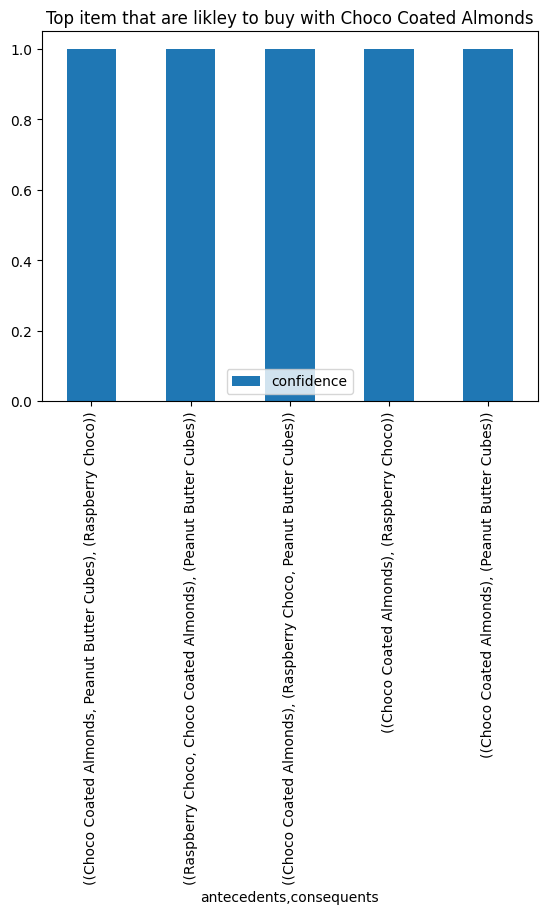

In [ ]:
rules[rules["antecedents"].apply(lambda x: "Choco Coated Almonds" in str(x))].groupby(
    ['antecedents', 'consequents'])[['confidence']].max().sort_values(ascending=False,
                                                                      by='confidence').head(10).plot(kind='bar').invert_xaxis()
plt.title('Top item that are likley to buy with Choco Coated Almonds');

#### **Penjelasan**
---
Dari plot di atas didapat bahwa 2 item dengan peluang tertinggi yang juga akan dibeli orang yang membeli Choco Coated Almonds adalah
- Rasberry Choco
- Peanut Butter Cubes



**Congratulations on completing the first part of this assignment!** 🎉🎉🎉